# Claim Prediction using Julia

In [1]:
include("utils.jl")
using .utils
using Flux, CSV, DataFrames, Statistics 
using Plots, MLJ, ClassImbalance
using MLJ: partition
using Flux: Dense, train!
using ClassImbalance: smote
using YeoJohnson

We load Australian private auto insurance claim data from 2004, sourced from R's 'CASdatasets' package. Original reference: P. De Jong and G.Z. Heller (2008), Generalized linear models for insurance data, Cambridge University Press.

In [89]:
data = DataFrame(CSV.File("../data/ausprivauto0405.csv"))

Row,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
,Float64,Float64,String15,String31,String7,String31,Int64,Int64,Float64
1,0.303901,1.06,old cars,Hatchback,Female,young people,0,0,0.0
2,0.648871,1.03,young cars,Hatchback,Female,older work. people,0,0,0.0
3,0.569473,3.26,young cars,Utility,Female,young people,0,0,0.0
4,0.317591,4.14,young cars,Station wagon,Female,young people,0,0,0.0
5,0.648871,0.72,oldest cars,Hatchback,Female,young people,0,0,0.0
6,0.854209,2.01,old cars,Hardtop,Male,older work. people,0,0,0.0
7,0.854209,1.6,old cars,Panel van,Male,older work. people,0,0,0.0
8,0.555784,1.47,young cars,Hatchback,Male,oldest people,0,0,0.0
9,0.361396,0.52,oldest cars,Hatchback,Female,working people,0,0,0.0


`ClaimOcc` is the target variable, and we create a binary indicator from it and drop `ClaimNb` and `ClaimAmount` as features.

In [90]:
data = select!(data, Not(:ClaimNb));
data = select!(data, Not(:ClaimAmount));

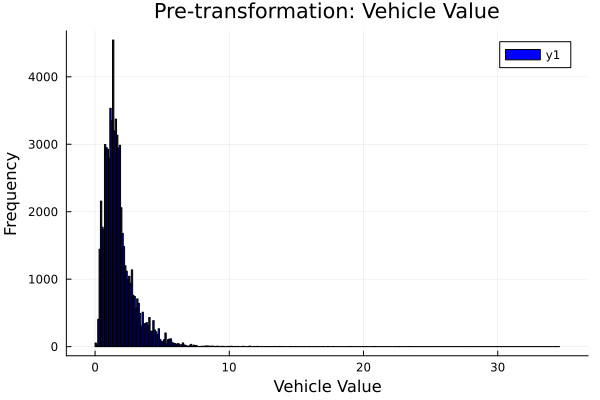

In [91]:
histogram(data[:, :VehValue], xlabel = "Vehicle Value", title = "Pre-transformation: Vehicle Value", 
    ylabel = "Frequency", 
    color = "blue")

We dummy encode our `DataFrame` and transform it into a matrix for Flux to interpret.

In [92]:
data_encode = Matrix{Float64}(dummyEncodeAll(data));

Below is the correlation matrix (post dummy variable encoding). It indicates that Exposure (row/col 1) has the highest positive correlation with claim occurrence.

In [93]:
cor(data_encode)

24×24 Matrix{Float64}:
  1.0          -0.000588404   0.0177538   …  -0.0143729     0.13298
 -0.000588404   1.0           0.200778        0.00629752    0.0184379
  0.0177538     0.200778      1.0             0.0123706     0.0175124
  0.0131467    -0.428516     -0.354037       -0.0343922    -0.0147564
 -0.053534      0.392094     -0.267064        0.0338324    -0.00155735
 -0.00880636    0.0366273    -0.04194     …   0.0413284    -0.0122331
  0.00210075    0.416806     -0.0156576      -0.0472632     0.00889231
  0.0145937     0.0337903    -0.0263802       0.00083748    0.00868939
  0.0275381    -0.0259387    -0.0104237       0.0249691     0.00600838
  0.00271413   -0.159731      0.0158743      -0.0525006    -0.00486594
  0.00763741    0.0512821    -0.0248309   …   0.0390562     0.00027578
 -0.0221287     0.0169358    -0.0320623       0.000991552   0.00814576
 -0.00953297   -0.00593678   -0.0430173      -0.0205451    -0.00335137
 -0.000280745   0.0411681    -0.0111427      -0.00704041    0

In [94]:
X = data_encode[:, 1:(end-1)]
y = data_encode[:, end];

Yeo-Johnson transformation is applied to normalise the features (as evident by the post-transformation histogram below).

In [95]:
for c ∈ 1:size(X, 2)
    X[:, c] = yeojohnson(X[:, c]);
end

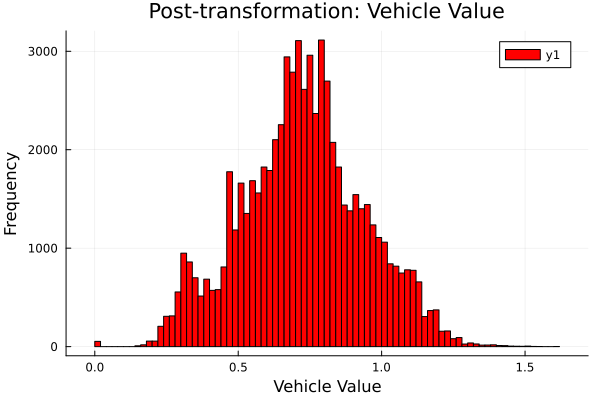

In [96]:
histogram(X[:, 2], xlabel = "Vehicle Value", title = "Post-transformation: Vehicle Value", 
    ylabel = "Frequency", 
    color = "red")

A low-variance filter with a threshold of 0.01 is applied, meaning any feature with a variance below 1%% is removed.

In [97]:
println("Pre low-variance filter: ", size(X, 2))

Pre low-variance filter: 23


In [98]:
X = lowVarianceFilter(X; t=0.01);

In [99]:
println("Post low-variance filter: ", size(X, 2))

Post low-variance filter: 13


We apply SMOTE in order to address class imbalance in the training set:

In [100]:
smote_X, smote_y = smote(X, vcat(y...), k = 5, pct_under = 200, pct_over = 100);

In [101]:
mean(smote_y)

0.5

In [102]:
mean(y)

0.06814430558830464

By using `partition()`, we ensure the distribution of out target variable is evenly dispersed:

In [103]:
train, test = partition(eachindex(y), 0.7);
train_X, train_y = smote_X, smote_y;

We keep a testing set imbalances like original data.

In [104]:
test_X = X[test, :];
test_y = y[test];

We construct an ANN with two hidden layer of 10 neurons and 6 neurons, respectively. The tanh activation function scales inputs between -1 and 1 and introduces non-linearity.

In [105]:
n_features = size(train_X, 2);
model = Chain(Dense(n_features, 5, tanh), Dense(5, 4, tanh), Dense(4, 1, sigmoid));
β = Flux.params(model);

ADAM is chosen as the optimiser and MSE the loss function:

In [106]:
δ = Flux.ADAM()
ℓ(x, y) = Flux.Losses.mse(model(x), y)

ℓ (generic function with 1 method)

We train using 5 000 epochs (for demonstrative purposes) and display the loss every N/10 epochs for transparency.

In [107]:
println("Starting training...")
@show ℓ(train_X', train_y')

Starting training...
ℓ(train_X', train_y') = 0.26071482222978004


0.26071482222978004

In [108]:
N = 50_000;

In [109]:
epochs = zeros(N)
for epoch ∈ 1:N
    # shuffle the data
    train_data = [train_X train_y][shuffle(1:end), :]
    train_X = train_data[:, 1:(end-1)]
    train_y = train_data[:, end]
    train_data = [(train_X', train_y')]
    # train the model
    Flux.train!(ℓ, β, train_data, δ)
    epochs[epoch] = ℓ(train_X', train_y')
    # print 100 epochs
    if epoch % (N/100) == 0
        @show epoch
        @show ℓ(train_X', train_y')
    end
end

epoch = 500
ℓ(train_X', train_y') = 0.2289328466056569
epoch = 1000
ℓ(train_X', train_y') = 0.22693684524113503
epoch = 1500
ℓ(train_X', train_y') = 0.22634650303091605
epoch = 2000
ℓ(train_X', train_y') = 0.22590514375460916
epoch = 2500
ℓ(train_X', train_y') = 0.22565037104381802
epoch = 3000
ℓ(train_X', train_y') = 0.22542628925867275
epoch = 3500
ℓ(train_X', train_y') = 0.2251617396999712
epoch = 4000
ℓ(train_X', train_y') = 0.22480488191848855
epoch = 4500
ℓ(train_X', train_y') = 0.2244425238999767
epoch = 5000
ℓ(train_X', train_y') = 0.22415913562420178
epoch = 5500
ℓ(train_X', train_y') = 0.2238909152626185
epoch = 6000
ℓ(train_X', train_y') = 0.22357061632881126
epoch = 6500
ℓ(train_X', train_y') = 0.22341987827873955
epoch = 7000
ℓ(train_X', train_y') = 0.22327898294841073
epoch = 7500
ℓ(train_X', train_y') = 0.22312385824459738
epoch = 8000
ℓ(train_X', train_y') = 0.22281588753728485
epoch = 8500
ℓ(train_X', train_y') = 0.22262570826137337
epoch = 9000
ℓ(train_X', train_y') =

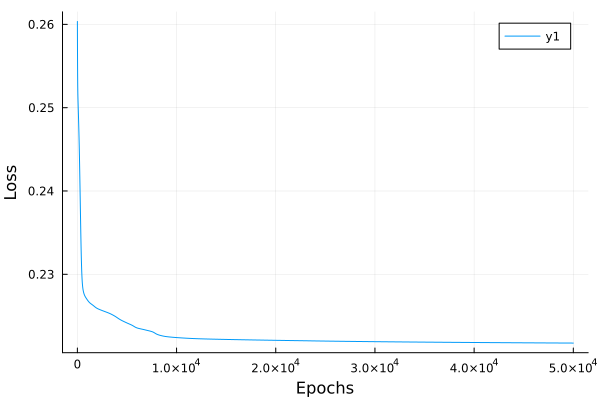

In [110]:
plot(1:N, epochs, xlabel = "Epochs", ylabel = "Loss")

Once trained, our model that generates the predictions assigns a 1 (at least one claim has occured) to all output values from the sigmoid output function greater than 0.5 and zero otherwise (no claim has occured).

In [111]:
predict(x) = model(x) .> 0.5

predict (generic function with 1 method)

Our final model can now be validated on unseen testing data:

In [112]:
CM = confusion_matrix(predict(test_X'), test_y')

┌ Warning: The classes are un-ordered,
│ using: negative='0.0' and positive='1.0'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/patrick/.julia/packages/MLJBase/6ooqv/src/measures/confusion_matrix.jl:116


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     0.0     │     1.0     │
├─────────────┼─────────────┼─────────────┤
│     0.0     │    9722     │     420     │
├─────────────┼─────────────┼─────────────┤
│     1.0     │    9148     │    1067     │
└─────────────┴─────────────┴─────────────┘


In [113]:
@show metrics(confusionMatrix(predict(test_X'), test_y'))

metrics(confusionMatrix(predict(test_X'), test_y')) = (Accuracy = 0.5299896841381343, Precision = 0.5152093269740329, Recall = 0.9585880496943404, F1_Score = 0.6702054322349373)


(Accuracy = 0.5299896841381343,
 Precision = 0.5152093269740329,
 Recall = 0.9585880496943404,
 F1_Score = 0.6702054322349373,)